1. Compressed vs original data, visual comparison
2. Quantification of "lossyness"
3. A few miscelenous data analysis

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, Optional
import hdf5plugin 

EXCLUDED_VARS = {
    "TAITIME", "contacts", "corner_lons", "corner_lats", "anchor"
}

In [23]:
original_path = "/discover/nobackup/projects/gmao/geos-s2s-3/GiOCEAN_e1/sfc_tavg_3hr_glo_L720x361_sfc/GiOCEAN_e1.sfc_tavg_3hr_glo_L720x361_sfc.monthly.199801.nc4"
compressed_path = "/home/sadhika8/JupyterLinks/nobackup/xbitinf_diagnostics_0.999/compressed_file.nc4"

In [24]:
# some sanity check for shape mismatch

ds_orig = xr.open_dataset(original_path)
ds_comp = xr.open_dataset(compressed_path)

print(ds_orig)

mismatches = []

for var in ds_orig.data_vars:
    if var not in ds_comp:
        mismatches.append((var, "Missing in compressed"))
        continue

    orig_dims = ds_orig[var].dims
    comp_dims = ds_comp[var].dims
    orig_shape = ds_orig[var].shape
    comp_shape = ds_comp[var].shape

    if orig_dims != comp_dims or orig_shape != comp_shape:
        mismatches.append((var, orig_dims, orig_shape, comp_dims, comp_shape))

print("Found", len(mismatches), "mismatches.")
for item in mismatches:
    print(item)

<xarray.Dataset> Size: 453MB
Dimensions:          (time: 1, lat: 361, lon: 720, lev: 72)
Coordinates:
  * lon              (lon) float64 6kB -180.0 -179.5 -179.0 ... 179.0 179.5
  * lat              (lat) float64 3kB -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * lev              (lev) float64 576B 1.0 2.0 3.0 4.0 ... 69.0 70.0 71.0 72.0
  * time             (time) datetime64[ns] 8B 1998-01-01T01:30:00
Data variables: (12/294)
    ANPRCP           (time, lat, lon) float32 1MB ...
    ASNOW            (time, lat, lon) float32 1MB ...
    BASEFLOW         (time, lat, lon) float32 1MB ...
    BCOOL            (time, lat, lon) float32 1MB ...
    CCWP             (time, lat, lon) float32 1MB ...
    CM               (time, lat, lon) float32 1MB ...
    ...               ...
    Var_WET1         (time, lat, lon) float32 1MB ...
    Var_WET2         (time, lat, lon) float32 1MB ...
    Var_WET3         (time, lat, lon) float32 1MB ...
    Var_Z0           (time, lat, lon) float32 1MB ...
    Var_Z

In [25]:
# lossyness quatification - write a function

import pandas as pd
import numpy as np

EXCLUDED_VARS = {
    "TAITIME", "contacts", "corner_lons", "corner_lats", "anchor"
}

def quantify_deviation(
    original_path: str | Path,
    compressed_path: str | Path,
    variables: Optional[Sequence[str]] = None,
) -> pd.DataFrame:
    op = Path(original_path)
    cp = Path(compressed_path)
    orig_ds = xr.open_dataset(op, mask_and_scale=False)
    comp_ds = xr.open_dataset(cp, mask_and_scale=False)

    if variables is None:
        variables = [
            v for v in orig_ds.data_vars
            if v in comp_ds.data_vars and v not in EXCLUDED_VARS
        ]
    else:
        variables = [v for v in variables if v not in EXCLUDED_VARS]

    if not variables:
        raise ValueError("No variables left after applying exclusions")

    rows = []
    for var in variables:
        da_o = orig_ds[var].squeeze(drop=True)
        da_c = comp_ds[var].squeeze(drop=True)

        # Align dimensions and coordinates
        da_o, da_c = xr.align(da_o, da_c, join="exact")

        if da_o.shape != da_c.shape:
            print(f"[WARNING] Shape mismatch for {var}: {da_o.shape} vs {da_c.shape}")
            rows.append((var, np.nan, np.nan))
            continue

        diff = (da_c - da_o).astype("float64")

        mask = np.isfinite(diff)
        if not mask.any():
            rows.append((var, np.nan, np.nan))
            continue

        diff_vals  = diff.where(mask, drop=True).values.ravel()
        orig_vals  = da_o.where(mask, drop=True).values.ravel()

        bias     = diff_vals.sum()
        denom1   = np.abs(orig_vals).sum()
        rel_bias = bias / denom1 if denom1 != 0 else np.nan

        rmse       = np.sqrt(np.mean(diff_vals**2))
        mean_abs_o = np.mean(np.abs(orig_vals))
        norm_rmse  = rmse / mean_abs_o if mean_abs_o != 0 else np.nan

        rows.append((var, rel_bias, norm_rmse))

    orig_ds.close()
    comp_ds.close()

    df = pd.DataFrame(rows, columns=["variable", "rel_bias", "norm_RMSE"])
    df.set_index("variable", inplace=True)
    print(df)
    return df


In [26]:
# run it

df_errors = quantify_deviation(
    original_path,
    compressed_path
) 

                rel_bias     norm_RMSE
variable                              
ANPRCP               NaN           NaN
ASNOW       0.000000e+00  0.000000e+00
BASEFLOW    0.000000e+00  0.000000e+00
BCOOL      -1.704676e-26  2.232601e-24
CCWP       -8.754466e-04  5.318478e-02
...                  ...           ...
Var_WET2    0.000000e+00  0.000000e+00
Var_WET3    0.000000e+00  0.000000e+00
Var_Z0     -2.554303e-04  6.979350e-02
Var_Z0H    -2.554360e-04  6.979352e-02
Var_ZETA_W -1.332009e-09  3.984548e-07

[294 rows x 2 columns]


In [27]:
df_errors.max()

rel_bias     0.000808
norm_RMSE    0.826623
dtype: float64

In [28]:
df_errors.mean()

rel_bias    -0.000239
norm_RMSE    0.018065
dtype: float64

In [29]:
df_errors.std()

rel_bias     0.001375
norm_RMSE    0.067662
dtype: float64

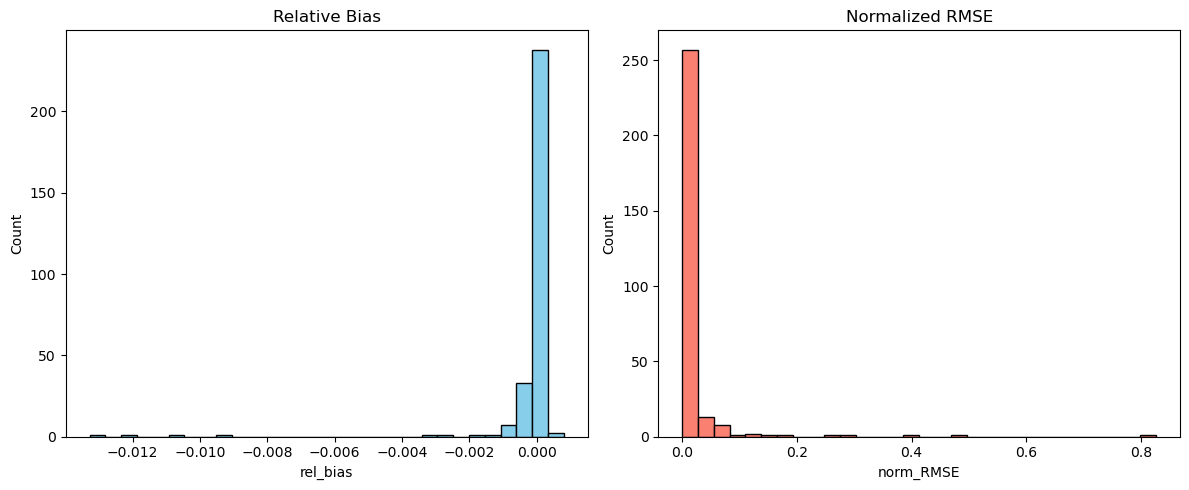

In [31]:
# error histograms

# Drop NaNs to avoid plotting issues
rel_bias_vals = df_errors["rel_bias"].dropna()
norm_rmse_vals = df_errors["norm_RMSE"].dropna()

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot rel_bias histogram
axes[0].hist(rel_bias_vals, bins=30, color="skyblue", edgecolor="black")
axes[0].set_title("Relative Bias")
axes[0].set_xlabel("rel_bias")
axes[0].set_ylabel("Count")

# Plot norm_RMSE histogram
axes[1].hist(norm_rmse_vals, bins=30, color="salmon", edgecolor="black")
axes[1].set_title("Normalized RMSE")
axes[1].set_xlabel("norm_RMSE")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


Analyzing variable: Var_PLS


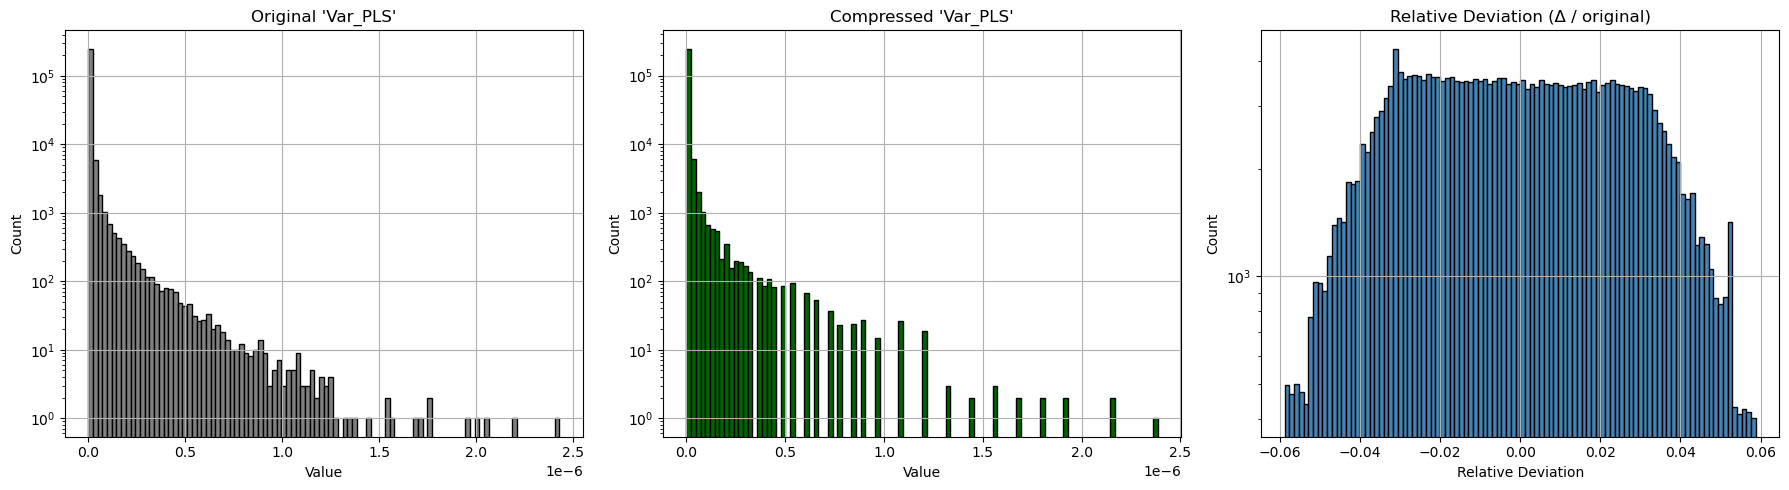

orig max/min: 2.4273147e-06 7.7627753e-38
comp max/min: 2.3841858e-06 7.6407133e-38


In [32]:
# more data comparison - relative deviation on a select variable

variable      =  "Var_PLS" #"Var_ZETA_W"       # or pick from variable_list

ds_orig = xr.open_dataset(original_path, mask_and_scale=False)
ds_comp = xr.open_dataset(compressed_path, mask_and_scale=False)

variable_list = [v for v in ds_orig.data_vars if v in ds_comp.data_vars]
#variable      =  "Var_PLS" #"Var_ZETA_W"       # or pick from variable_list
print(f"Analyzing variable: {variable}")

# align
da_o = ds_orig[variable].squeeze(drop=True)
da_c = ds_comp[variable].squeeze(drop=True)
da_o, da_c = xr.align(da_o, da_c, join="exact")

# values
mask       = np.isfinite(da_o) & np.isfinite(da_c) & (da_o != 0)
orig_vals  = da_o.where(mask, drop=True).values.ravel()
comp_vals  = da_c.where(mask, drop=True).values.ravel()
rel_dev    = ((da_c - da_o) / da_o).where(mask, drop=True).values.ravel()

# three-panel histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(orig_vals, bins=100, color="gray",      edgecolor="black")
axes[0].set_title(f"Original '{variable}'")
axes[0].set_xlabel("Value"); axes[0].set_ylabel("Count")
axes[0].set_yscale("log"); axes[0].grid(True)

axes[1].hist(comp_vals, bins=100, color="darkgreen", edgecolor="black")
axes[1].set_title(f"Compressed '{variable}'")
axes[1].set_xlabel("Value"); axes[1].set_ylabel("Count")
axes[1].set_yscale("log"); axes[1].grid(True)

axes[2].hist(rel_dev,  bins=100, color="steelblue", edgecolor="black")
axes[2].set_title("Relative Deviation (Δ / original)")
axes[2].set_xlabel("Relative Deviation"); axes[2].set_ylabel("Count")
axes[2].set_yscale("log"); axes[2].grid(True)

plt.tight_layout(); plt.show()

print("orig max/min:", np.nanmax(orig_vals), np.nanmin(orig_vals))
print("comp max/min:", np.nanmax(comp_vals), np.nanmin(comp_vals))

ds_orig.close(); ds_comp.close()